# Analysis on CNN/DM

Current structure:
* each metric has a DataFrame, df_metric
* df_metric has the score on all samples, from all models
* order of samples is consistent across different dfs, (i.e. different metrics)
* each df also has ordered labels

Correlations are of two types, as in this image:
* Sample Level
    * Take correlation b/w scores for models on EACH sample
    * Average over all samples

![sample](corr-sample.png)
![model](corr-model.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [4]:
cnndir = '../cnndm-300/'

df_r1 = pd.read_csv(os.path.join(cnndir, 'df_rouge1.csv'))
df_r2 = pd.read_csv(os.path.join(cnndir, 'df_rouge2.csv'))
df_rL = pd.read_csv(os.path.join(cnndir, 'df_rougeL.csv'))

df_m1 = pd.read_csv(os.path.join(cnndir, 'df_mvrs1.csv'))
# df_m2 = pd.read_csv(os.path.join(cnndir, 'df_mvrs2.csv'))

df_bs = pd.read_csv(os.path.join(cnndir, 'df_berts.csv'))

df_hu = pd.read_csv(os.path.join(cnndir, 'df_pyramid.csv'))

In [5]:
df_r1.mean()

ext_heter_graph     0.433145
ext_matchsumm       0.458299
abs_bart            0.458390
ext_refresh         0.410478
abs_two_stage_rl    0.430421
abs_neusumm         0.425958
abs_bottom_up       0.412681
abs_semsim          0.468189
abs_unilm           0.440964
ext_bart            0.460962
ext_banditsumm      0.426751
dtype: float64

In [6]:
df_m1.head()

,labels,ext_heter_graph,ext_matchsumm,abs_bart,ext_refresh,abs_two_stage_rl,abs_neusumm,abs_bottom_up,abs_semsim,abs_unilm,ext_bart,ext_banditsumm
0,inference,0.222678,0.242371,0.349924,0.246333,0.179134,0.214655,0.199219,0.373822,0.261881,0.408623,0.239429
1,paraphrase,0.244997,0.298752,0.346585,0.244327,0.293213,0.261928,0.267363,0.299880,0.249531,0.311946,0.308799
2,entity,0.280869,0.286595,0.291921,0.171201,0.262809,0.279815,0.247640,0.238414,0.189454,0.262694,0.294107
3,inference,0.283762,0.338868,0.404927,0.296955,0.197324,0.298342,0.226352,0.380236,0.268166,0.358614,0.314634
4,paraphrase,0.210981,0.249807,0.216717,0.222922,0.263831,0.283888,0.255156,0.245165,0.251810,0.230077,0.188267


In [7]:
from collections import Counter

In [8]:
Counter(df_m1.head(200).labels)

Counter({'inference': 40,
         'paraphrase': 88,
         'entity': 11,
         'evidence': 25,
         'extractive': 36})

In [9]:
np.mean(df_m1.mean())

0.2872797526538586

In [10]:
by_label = df_r1.groupby('labels').mean()
by_label

,ext_heter_graph,ext_matchsumm,abs_bart,ext_refresh,abs_two_stage_rl,abs_neusumm,abs_bottom_up,abs_semsim,abs_unilm,ext_bart,ext_banditsumm
labels,,,,,,,,,,,
entity,0.357971,0.383066,0.398121,0.367980,0.364062,0.353765,0.354680,0.394973,0.326147,0.372363,0.361246
evidence,0.457284,0.481798,0.453859,0.433843,0.432247,0.467485,0.433801,0.464059,0.448615,0.472435,0.446316
extractive,0.509008,0.523816,0.516989,0.472693,0.516138,0.497994,0.470713,0.530509,0.531551,0.531057,0.503085
inference,0.403795,0.439039,0.440562,0.362120,0.404801,0.401737,0.372280,0.450027,0.424855,0.433394,0.393995
paraphrase,0.417991,0.442979,0.451342,0.405682,0.414776,0.404724,0.408554,0.461277,0.423406,0.452632,0.413043


In [11]:
avg_labels = by_label.mean(axis=1)
avg_labels

labels
entity        0.366761
evidence      0.453795
extractive    0.509414
inference     0.411510
paraphrase    0.426946
dtype: float64

In [12]:
series_all = pd.Series([np.mean(df_m1.mean())], index=['all'])
series_all

all    0.28728
dtype: float64

In [13]:
avg_labels.append(series_all)

entity        0.366761
evidence      0.453795
extractive    0.509414
inference     0.411510
paraphrase    0.426946
all           0.287280
dtype: float64

## Basic `bucket` analysis

In [14]:
mnames = ['rouge1', 'rouge2', 'rougeL', 'mvr1', 'berts', 'hpyr']
mdfs = []
for x in [df_r1, df_r2, df_rL, df_m1, df_bs, df_hu]:
    mdfs.append(x.head(100))

mdatas = [x.values[:, 1:] for x in mdfs]

assert len(mnames) == len(mdfs)

In [15]:
overview = []

for name, df in zip(mnames, mdfs):
    score_models_full = df.mean()  # Mean across all samples, for each model => 1 x N_models
    score_avg = np.mean(score_models_full)  # Mean across all models  => 1 x 1
    
    gb_label = df.groupby('labels').mean()  # GB labels, mean across group samples, for each model => N_labels x N_models
    score_label = gb_label.mean(axis=1)  # In each group, mean across all models => N_labels x 1
    
    series_avg = pd.Series([score_avg], index=['all'])
    
    overview.append(score_label.append(series_avg))

In [16]:
df_r1.head(100).groupby('labels').mean()

,ext_heter_graph,ext_matchsumm,abs_bart,ext_refresh,abs_two_stage_rl,abs_neusumm,abs_bottom_up,abs_semsim,abs_unilm,ext_bart,ext_banditsumm
labels,,,,,,,,,,,
entity,0.395214,0.408566,0.410690,0.358630,0.403283,0.411335,0.441192,0.456359,0.369579,0.404273,0.419836
evidence,0.431012,0.473990,0.442010,0.404969,0.394875,0.448867,0.392165,0.445867,0.430404,0.454780,0.415264
extractive,0.551425,0.553070,0.531479,0.485644,0.540554,0.511252,0.481813,0.547440,0.539712,0.562610,0.540948
inference,0.378547,0.422590,0.437282,0.357796,0.394052,0.378966,0.332426,0.445692,0.417851,0.437693,0.386853
paraphrase,0.416411,0.437555,0.455012,0.396343,0.420850,0.408283,0.404138,0.463454,0.438083,0.461833,0.415021


In [17]:
df_overview = pd.DataFrame(overview)
df_overview.index = mnames

In [18]:
df_overview

,entity,evidence,extractive,inference,paraphrase,all
rouge1,0.407178,0.430382,0.531450,0.399068,0.428817,0.440663
rouge2,0.157011,0.184637,0.335871,0.170742,0.178545,0.205173
rougeL,0.234541,0.278317,0.419766,0.266229,0.277143,0.299069
mvr1,0.239999,0.266171,0.340262,0.263900,0.274334,0.281761
berts,0.875752,0.882711,0.897925,0.875108,0.880394,0.882585
hpyr,0.394484,0.426866,0.580177,0.439947,0.480800,0.480593


In [19]:
## Factcc
import csv
with open('factcc_bacc.txt') as fp:
    reader = csv.reader(fp)
    bacc_row = pd.Series({a:float(b) for a,b in reader}, name='bacc')

print(bacc_row)

entity        0.833682
all           0.827291
evidence      0.797220
paraphrase    0.830456
inference     0.782664
extractive    0.889609
Name: bacc, dtype: float64


In [20]:
df_overview = df_overview.append(bacc_row)
df_overview

,entity,evidence,extractive,inference,paraphrase,all
rouge1,0.407178,0.430382,0.531450,0.399068,0.428817,0.440663
rouge2,0.157011,0.184637,0.335871,0.170742,0.178545,0.205173
rougeL,0.234541,0.278317,0.419766,0.266229,0.277143,0.299069
mvr1,0.239999,0.266171,0.340262,0.263900,0.274334,0.281761
berts,0.875752,0.882711,0.897925,0.875108,0.880394,0.882585
hpyr,0.394484,0.426866,0.580177,0.439947,0.480800,0.480593
bacc,0.833682,0.797220,0.889609,0.782664,0.830456,0.827291


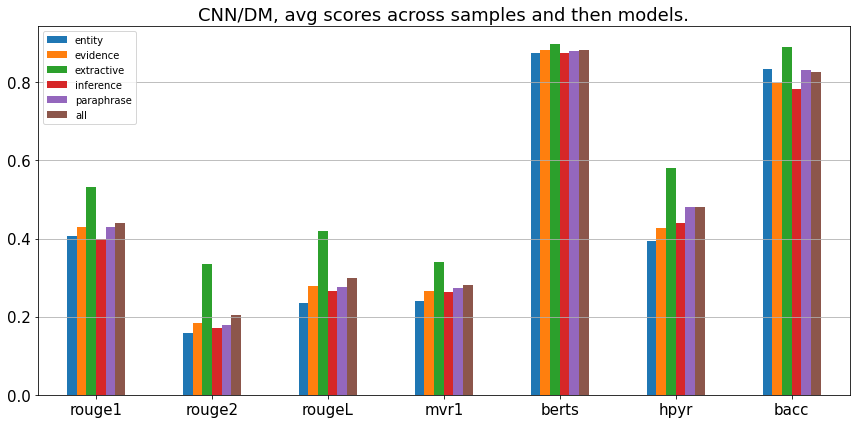

In [33]:
df_overview.plot.bar(rot=0, figsize=(12, 6), fontsize=15);

plt.title('CNN/DM, avg scores across samples and then models.', fontsize=18)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('overview_cnndm_buckets.png')

In [23]:
mnames

['rouge1', 'rouge2', 'rougeL', 'mvr1', 'berts', 'hpyr']

In [24]:
ordered_cols = ['position', 'entity', 'evidence', 'extractive', 'paraphrase', 'inference', 'all']
groups_tikz = df_overview.round(2).copy()
groups_tikz['position'] = list(range(1, len(mnames)+2))
groups_tikz[ordered_cols].to_csv('./cnndm_group_data.txt', index=False, header=False, sep=' ')

In [27]:
cat ./cnndm_group_data.txt

1 0.41 0.43 0.53 0.43 0.4 0.44
2 0.16 0.18 0.34 0.18 0.17 0.21
3 0.23 0.28 0.42 0.28 0.27 0.3
4 0.24 0.27 0.34 0.27 0.26 0.28
5 0.88 0.88 0.9 0.88 0.88 0.88
6 0.39 0.43 0.58 0.48 0.44 0.48
7 0.83 0.8 0.89 0.83 0.78 0.83


## System Rank correlations

In [28]:
import itertools
from collections import defaultdict

In [29]:
df_r1[df_r1.labels == 'evidence'].head()

,labels,ext_heter_graph,ext_matchsumm,abs_bart,ext_refresh,abs_two_stage_rl,abs_neusumm,abs_bottom_up,abs_semsim,abs_unilm,ext_bart,ext_banditsumm
8,evidence,0.491525,0.537037,0.423729,0.497041,0.491228,0.541667,0.437500,0.491525,0.300000,0.477064,0.491525
11,evidence,0.492308,0.492308,0.442478,0.440252,0.390244,0.425532,0.343434,0.418605,0.487395,0.444444,0.451128
15,evidence,0.338462,0.356589,0.452830,0.379085,0.262626,0.375940,0.307692,0.351145,0.469565,0.453782,0.372881
17,evidence,0.384000,0.712121,0.589928,0.416667,0.524590,0.529801,0.432000,0.490798,0.487805,0.465116,0.412698
22,evidence,0.439024,0.461538,0.466019,0.519481,0.481481,0.612903,0.588235,0.528302,0.527273,0.491228,0.678899


In [30]:
df_m1[df_m1.labels == 'evidence'].head()

,labels,ext_heter_graph,ext_matchsumm,abs_bart,ext_refresh,abs_two_stage_rl,abs_neusumm,abs_bottom_up,abs_semsim,abs_unilm,ext_bart,ext_banditsumm
8,evidence,0.219336,0.282586,0.231875,0.258993,0.281855,0.284702,0.275753,0.289062,0.125079,0.251756,0.235223
11,evidence,0.274400,0.272400,0.229708,0.234864,0.226473,0.246566,0.198312,0.237846,0.286744,0.234999,0.258522
15,evidence,0.160265,0.156084,0.296767,0.207610,0.146448,0.178226,0.130636,0.184165,0.299529,0.255429,0.227081
17,evidence,0.201588,0.462570,0.388008,0.256071,0.313615,0.316322,0.186429,0.372526,0.350112,0.311164,0.189222
22,evidence,0.290202,0.250692,0.295697,0.262162,0.244439,0.372751,0.388321,0.329419,0.325794,0.307588,0.373232


In [31]:
mnames

['rouge1', 'rouge2', 'rougeL', 'mvr1', 'berts', 'hpyr']

In [32]:
pearson_heatmap = np.eye(len(mnames))
spearman_heatmap = np.eye(len(mnames))

label_pear_heatmap = defaultdict(lambda : defaultdict(list))
label_sprm_heatmap = defaultdict(lambda : defaultdict(list))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.permutations(range(len(mnames)), 2):
    if m2 != m1:
        pearson_vals = []
        spearman_vals = []
        
        for i in range(100):
            row1 = mdatas[m1][i].tolist()
            row2 = mdatas[m2][i].tolist()
            rowlabel = ordered_labels[i]
            
            pr_score, pr_pval = pearsonr(row1, row2)
            if not np.isnan(pr_score):
                pearson_vals.append(pr_score)
                label_pear_heatmap[rowlabel][(m1, m2)].append(pr_score)
                
            sm_score, sm_pval = spearmanr(row1, row2)
            if not np.isnan(sm_score):
                spearman_vals.append(sm_score)
                label_sprm_heatmap[rowlabel][(m1, m2)].append(sm_score)
                
        pearson_heatmap[m1, m2] = np.nanmean(pearson_vals)
        spearman_heatmap[m1, m2] = np.nanmean(spearman_vals)

In [33]:
np.round(pearson_heatmap, 2)

array([[1.  , 0.76, 0.67, 0.85, 0.76, 0.36],
       [0.76, 1.  , 0.7 , 0.75, 0.69, 0.35],
       [0.67, 0.7 , 1.  , 0.69, 0.69, 0.3 ],
       [0.85, 0.75, 0.69, 1.  , 0.82, 0.37],
       [0.76, 0.69, 0.69, 0.82, 1.  , 0.31],
       [0.36, 0.35, 0.3 , 0.37, 0.31, 1.  ]])

In [34]:
with open('./cnndm_pearson.npy', 'wb') as fp:
    np.save(fp, pearson_heatmap)

In [44]:
np.round(spearman_heatmap, 2)

array([[1.  , 0.72, 0.63, 0.8 , 0.71, 0.34],
       [0.72, 1.  , 0.66, 0.7 , 0.64, 0.34],
       [0.63, 0.66, 1.  , 0.65, 0.67, 0.28],
       [0.8 , 0.7 , 0.65, 1.  , 0.78, 0.37],
       [0.71, 0.64, 0.67, 0.78, 1.  , 0.31],
       [0.34, 0.34, 0.28, 0.37, 0.31, 1.  ]])

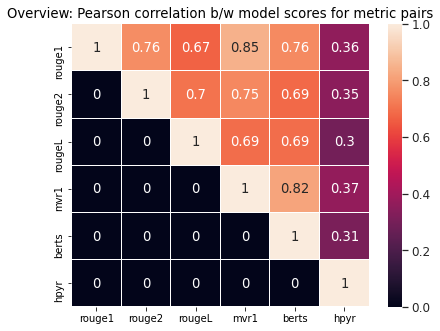

In [41]:
fig, ax = plt.subplots(figsize=(5.8, 4.8))
sns.set(font_scale=1.1)
sns.heatmap(pearson_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Pearson correlation b/w model scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_pearson.png')

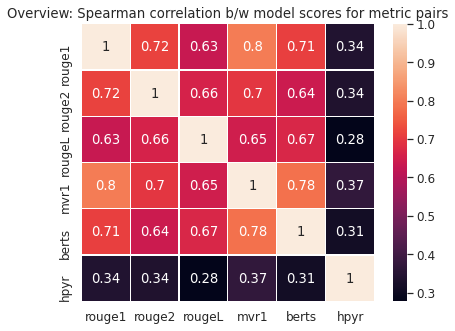

In [45]:
fig, ax = plt.subplots(figsize=(5.8, 4.8))
sns.set(font_scale=1.1)
sns.heatmap(spearman_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Spearman correlation b/w model scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_spearman.png')

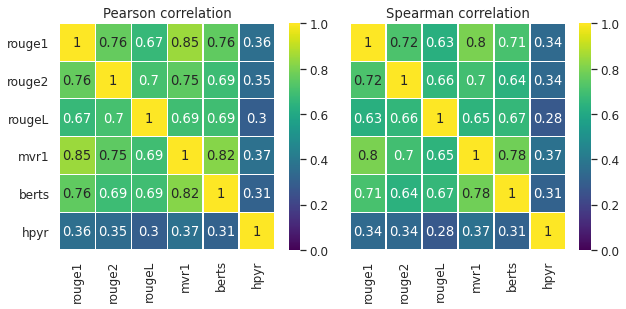

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)
sns.set(font_scale=1.1)

sns.heatmap(pearson_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
            annot=True, ax=ax[0], cmap='viridis', vmin=0, vmax=1);
ax[0].set_title('Pearson correlation')

for tick in ax[0].get_yticklabels():
    tick.set_rotation(0)

sns.heatmap(spearman_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1,
            annot=True, ax=ax[1], cmap='viridis', vmin=0, vmax=1);
ax[1].set_title('Spearman correlation')

# sns.color_palette("viridis", as_cmap=True)

plt.tight_layout()
plt.savefig('cnn_heatmaps_overview.png')

### System Rank, `bucket` level

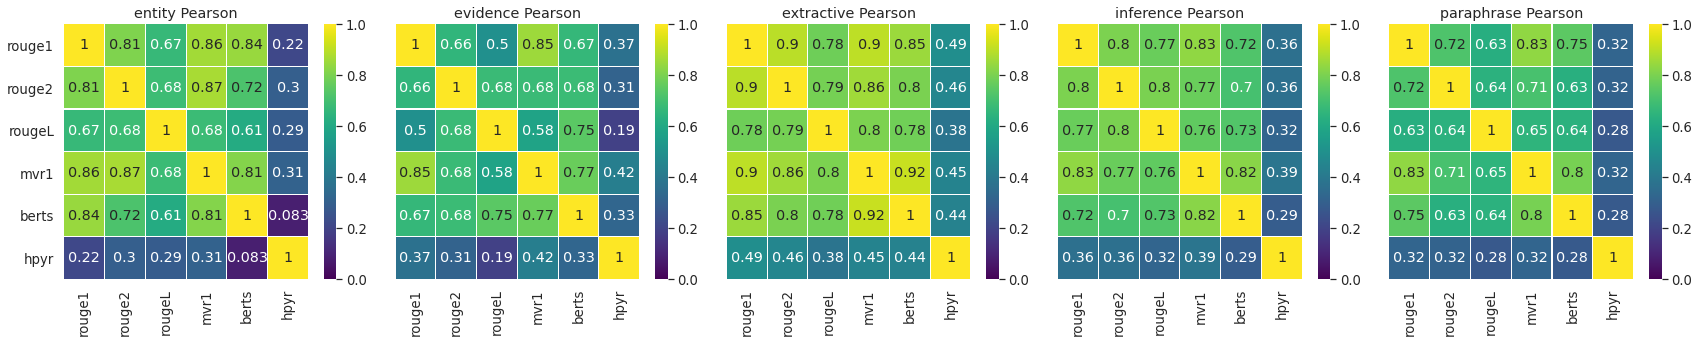

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=True)
axes = axes.flatten()
i = 0

sns.set(font_scale=1.2)
for label, hmdata in sorted(label_pear_heatmap.items()):
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
        
    sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
                annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1);
    
    ax.set_title('%s Pearson' % label);
    i += 1
    

for tick in axes[0].get_yticklabels():
    tick.set_rotation(0)
    
fig.tight_layout()
fig.savefig('cnn_labels_pearson.png')

/projects/anaconda3/envs/moverscore/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


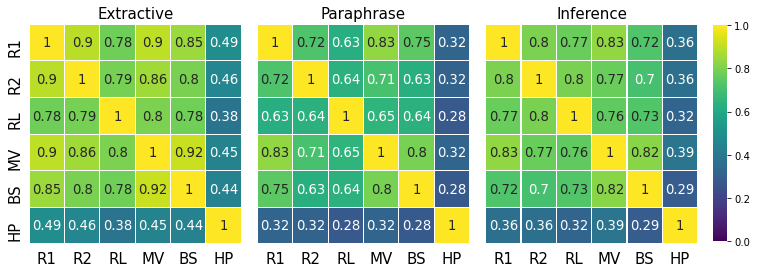

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axes = axes.flatten()
i = 0

cbar_ax = fig.add_axes([1, 0.135, .02, 0.75])

# for label, hmdata in sorted(label_pear_heatmap.items()):
for label, hmdata in [('Extractive', label_pear_heatmap['extractive']),
                      ('Paraphrase', label_pear_heatmap['paraphrase']),
                      ('Inference', label_pear_heatmap['inference'])]:
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
    
    ticklabels = ['R1', 'R2', 'RL', 'MV', 'BS', 'HP']
    
    sns.set(font_scale=1.1)
    
    b = sns.heatmap(subhm, xticklabels=ticklabels, yticklabels=ticklabels, linewidths=0.1, 
            annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1, 
                    cbar=True if i == 2 else False, cbar_ax=cbar_ax if i == 2 else None);
    
    b.set_xticklabels(ticklabels, size = 15)
    b.set_yticklabels(ticklabels, size = 15)
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    ax.set_title(label, fontsize=15);
    i += 1
    
fig.tight_layout()
fig.savefig('cnndm_complexity_pearson.jpg', dpi=300, bbox_inches='tight')

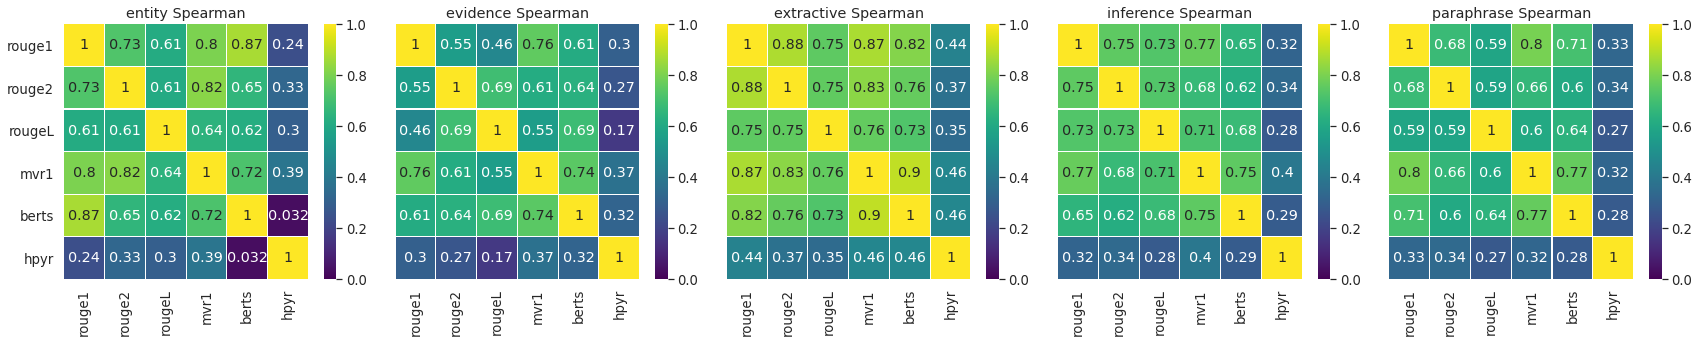

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=True)
axes = axes.flatten()
i = 0

sns.set(font_scale=1.2)
for label, hmdata in sorted(label_sprm_heatmap.items()):
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
        
    sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
                annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1);
    ax.set_title('%s Spearman' % label);
    i += 1
    
for tick in axes[0].get_yticklabels():
    tick.set_rotation(0)
    
fig.tight_layout()
fig.savefig('cnn_labels_spearman.png')

## Sample Correlation

In [31]:
samples_pearson = np.eye(len(mnames))
samples_spearman = np.eye(len(mnames))

samples_label_pear = defaultdict(lambda : np.eye(len(mnames)))
samples_label_sprm = defaultdict(lambda : np.eye(len(mnames)))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.combinations(range(len(mnames)), 2):
    if m2 > m1:
        over_pr = np.nanmean(
            [pearsonr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_pearson[m1, m2] = over_pr
        
        over_sm = np.nanmean(
            [spearmanr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_spearman[m1, m2] = over_sm
        
        tempdf1 = mdfs[m1]
        tempdf2 = mdfs[m2]
        for label in set(ordered_labels):
            subset_pr = np.nanmean(
                [pearsonr(tempdf1[tempdf1['labels'] == label][model], 
                          tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_pear[label][m1, m2] = subset_pr
            
            subset_sm = np.nanmean(
                [spearmanr(tempdf1[tempdf1['labels'] == label][model], 
                           tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_sprm[label][m1, m2] = subset_sm

In [32]:
label, subset_pr, subset_sm

('entity', 0.5019747989861725, 0.483163948830235)

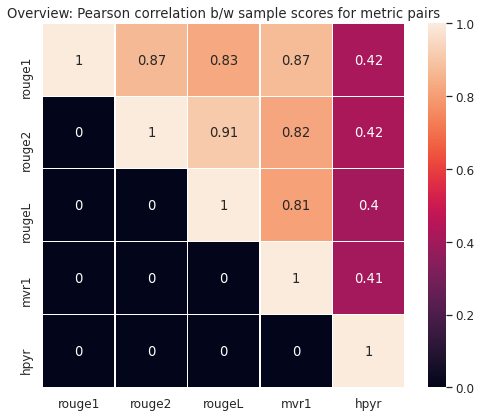

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_pearson, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Pearson correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_pearson.png')

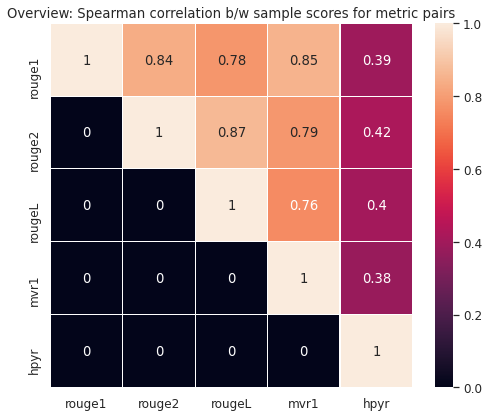

In [34]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_spearman, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Spearman correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_spearman.png')

In [35]:
np.nanmean(
    [spearmanr(df_r1[df_r1.labels == 'extractive'][model], 
               df_m1[df_m1.labels == 'extractive'][model])[0] for model in df_r1.columns[1:]]
)

0.8981468668997362

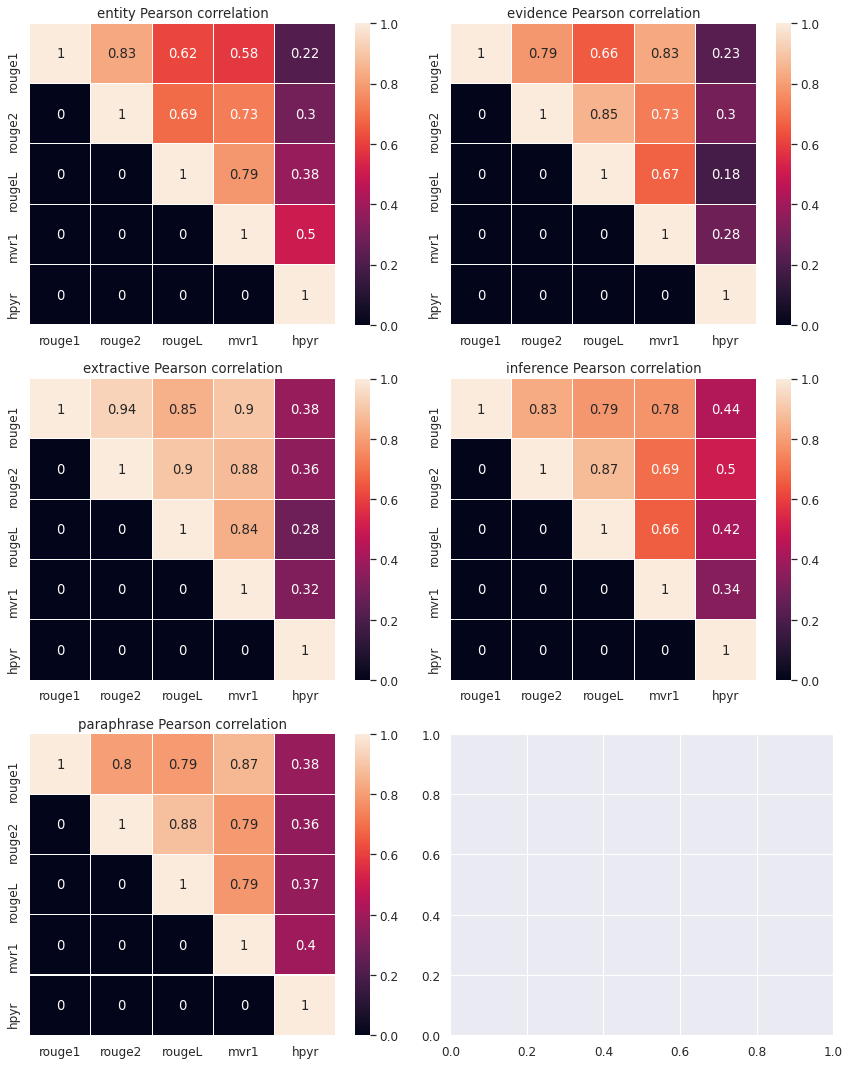

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_pear.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Pearson correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_pearson.png')

In [37]:
label, hmdata

('paraphrase',
 array([[1.        , 0.80411734, 0.79481693, 0.86693363, 0.37760739],
        [0.        , 1.        , 0.88285298, 0.79285487, 0.36384855],
        [0.        , 0.        , 1.        , 0.78825342, 0.37413582],
        [0.        , 0.        , 0.        , 1.        , 0.39561876],
        [0.        , 0.        , 0.        , 0.        , 1.        ]]))

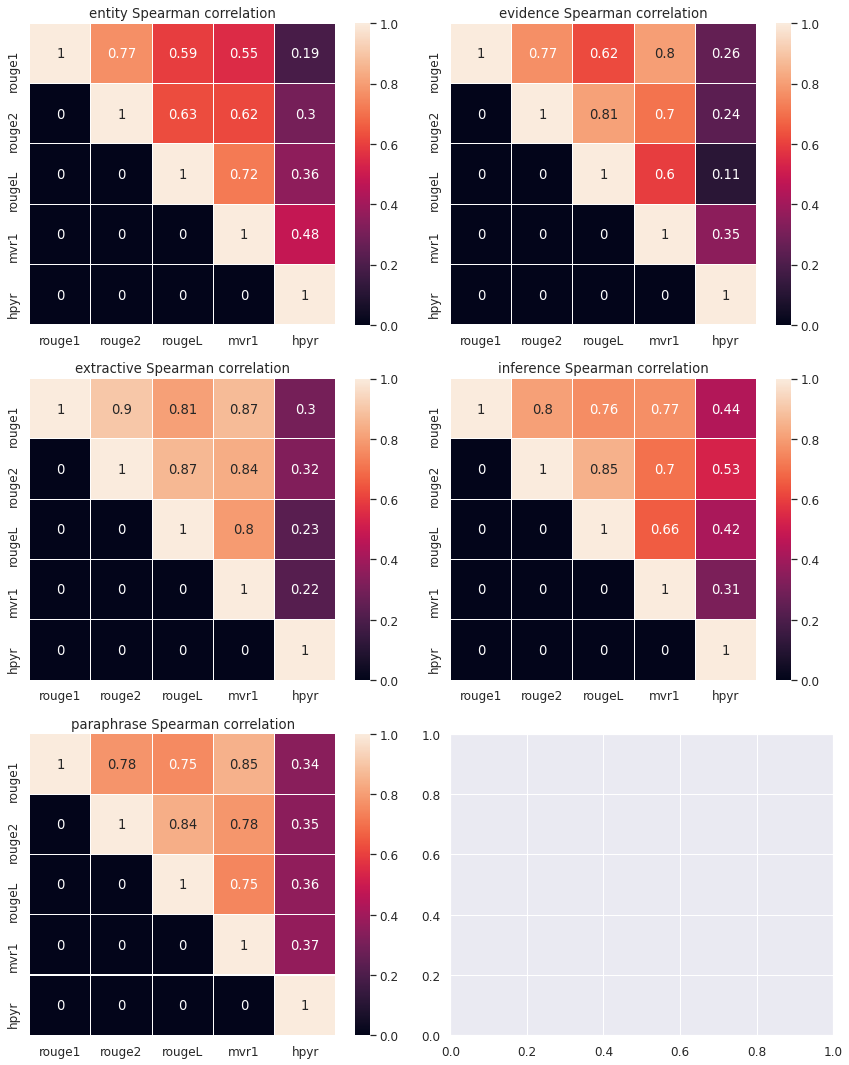

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_sprm.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Spearman correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_spearman.png')

In [38]:
np.round(samples_label_sprm['extractive'], 2)

array([[1.  , 0.89, 0.93, 0.84, 0.83],
       [0.  , 1.  , 0.9 , 0.8 , 0.78],
       [0.  , 0.  , 1.  , 0.84, 0.84],
       [0.  , 0.  , 0.  , 1.  , 0.99],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

## Manual analysis